In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using device: {device}')

using device: cuda


## Data

In [3]:
#creating some data from Linear Regression formula
weight = 0.6
bias = 0.4

start = 0
end = 1
step = 0.02

X = torch.arange(start,end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4120],
         [0.4240],
         [0.4360],
         [0.4480],
         [0.4600],
         [0.4720],
         [0.4840],
         [0.4960],
         [0.5080]]))

In [4]:
#split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [5]:
def plot_predict(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    # plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")
    plt.scatter(test_data, test_labels , c='y', s=4, label="Test data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    plt.legend(prop={'size': 14})

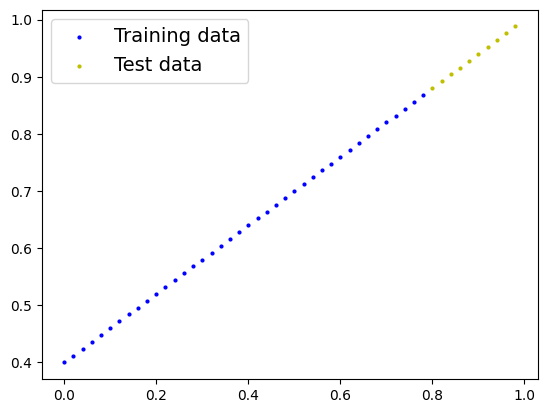

In [6]:
# plotting the data
plot_predict()

## Building a pytorch linear model

In [7]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # Using nn.Linear() for creating linear params, also called 
        # -> linear transform, probing layer, Dense layer, fully connected layer
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)        

torch.manual_seed(42)
model_1 = LinearModel()
print(model_1,model_1.state_dict())

LinearModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
) OrderedDict({'linear_layer.weight': tensor([[0.7645]]), 'linear_layer.bias': tensor([0.8300])})


In [8]:
# check the model device
model_1.to(device) # sets to gpu
next(model_1.parameters()).device # default = cpu

device(type='cuda', index=0)

## Training

In [9]:
# setting a loss func
loss_fn = nn.L1Loss()
# setting an optimizers
optim = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [10]:
%%time
# Training Loop
torch.manual_seed(42)
epochs = 200
# put data on target device (using device agnostic code)
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
for epoch in range(epochs):
    model_1.train()

    #Forward pass
    y_pred = model_1(X_train)
    #Calculate the loss
    loss = loss_fn(y_pred, y_train)
    #Optimizers to zero grad
    optim.zero_grad()
    #Perform Backpropagation
    loss.backward()
    #Optimizer step
    optim.step()

    ### Tesing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    #Logging
    if epoch %10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.3f}% | Test Loss: {test_loss:.3f}%')
        

Epoch: 0 | Loss: 0.494% | Test Loss: 0.558%
Epoch: 10 | Loss: 0.355% | Test Loss: 0.369%
Epoch: 20 | Loss: 0.216% | Test Loss: 0.180%
Epoch: 30 | Loss: 0.077% | Test Loss: 0.010%
Epoch: 40 | Loss: 0.047% | Test Loss: 0.139%
Epoch: 50 | Loss: 0.041% | Test Loss: 0.110%
Epoch: 60 | Loss: 0.026% | Test Loss: 0.035%
Epoch: 70 | Loss: 0.018% | Test Loss: 0.036%
Epoch: 80 | Loss: 0.010% | Test Loss: 0.021%
Epoch: 90 | Loss: 0.002% | Test Loss: 0.001%
Epoch: 100 | Loss: 0.002% | Test Loss: 0.004%
Epoch: 110 | Loss: 0.001% | Test Loss: 0.000%
Epoch: 120 | Loss: 0.001% | Test Loss: 0.002%
Epoch: 130 | Loss: 0.001% | Test Loss: 0.001%
Epoch: 140 | Loss: 0.002% | Test Loss: 0.002%
Epoch: 150 | Loss: 0.000% | Test Loss: 0.002%
Epoch: 160 | Loss: 0.002% | Test Loss: 0.002%
Epoch: 170 | Loss: 0.000% | Test Loss: 0.000%
Epoch: 180 | Loss: 0.000% | Test Loss: 0.002%
Epoch: 190 | Loss: 0.000% | Test Loss: 0.001%
CPU times: total: 1.03 s
Wall time: 3.06 s


In [11]:
(weight, bias), (model_1.state_dict())

((0.6, 0.4),
 OrderedDict([('linear_layer.weight', tensor([[0.5997]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3996], device='cuda:0'))]))

In [12]:
# turn model to eval() to make evaluation/prediction
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8793],
        [0.8913],
        [0.9033],
        [0.9153],
        [0.9273],
        [0.9393],
        [0.9513],
        [0.9633],
        [0.9753],
        [0.9872]], device='cuda:0')

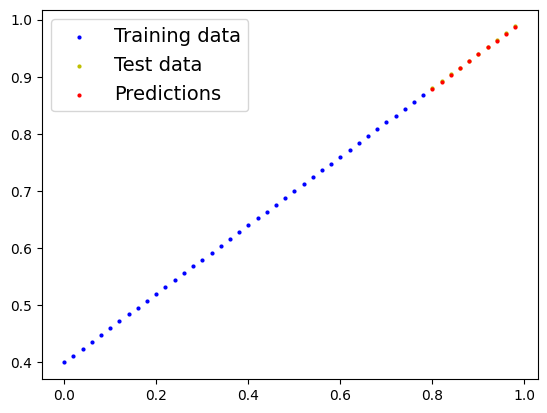

In [13]:
plot_predict(predictions=y_preds.cpu())

## Saving and Loading the model

In [85]:
from pathlib import Path

MODEL_PATH=Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME='01_model_1.pth'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

print(f'Saving model: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model: models\01_model_1.pth


In [14]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5997]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3996], device='cuda:0'))])

In [17]:
# Loading a model
from pathlib import Path
MODEL_PATH=Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME='01_model_1.pth'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME
# create new instance of model
loaded_model_1 = LinearModel()

# Load the saved model
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))

#Put the loaded model to device
loaded_model_1.to(device)

LinearModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [18]:
loaded_model_1.state_dict() , model_1.state_dict()

(OrderedDict([('linear_layer.weight', tensor([[0.5997]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3996], device='cuda:0'))]),
 OrderedDict([('linear_layer.weight', tensor([[0.5997]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3996], device='cuda:0'))]))

In [19]:
# Evaluate thee loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_y_preds = loaded_model_1(X_test)

y_preds==loaded_y_preds 

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')